<a href="https://colab.research.google.com/github/Chia-Tien-Tang/Deep-Learning-in-Practice_Assignment/blob/main/TP4/TP4_Transfer_Learning_and_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small.

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :**

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation.

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [18]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

In [19]:
BATCH_SIZE = 10

transform_train = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.RandomCrop(32, padding=4),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_set = datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=transform_train
    )

# Create a subset containing only the first 100 samples
subset_indices = list(range(100))
subset_cifar_train = Subset(train_set, subset_indices)

train_loader = DataLoader(
    subset_cifar_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Files already downloaded and verified


* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project.

* The remaining samples correspond to $\mathcal{X}$.

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

The evalution of the training procedure is difficult as we limited ourselves with the training set $\mathcal{X}_{\text{train}}$ of 100 samples, instead of fully utilizing 50000 available samples. As a result, we have small data to train a model, which would likely to result in the development of an overfitting model. There are several solutions that could mediate small data problem. They are data augmentation, multi-tasking, and transfer learning. Data augmentation solution applies transformations to the samples in order to reduce biases in the model. Multi-tasking uses different samples with features that are related to the task of interest. Lastly, transfer learning requires a model to be trained on a bigger dataset prior to training on a smaller dataset.

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf.

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse

In [ ]:
#Load whole testing set
BATCH_SIZE = 10

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True,
    transform=transform_test
    )
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [ ]:
best_acc = 0

def train(epoch, train_loader):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()


    acc = 100.*correct/total
    return train_loss, acc





def test(epoch, test_loader):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    acc = 100.*correct/total

    if acc > best_acc:
      best_acc = acc

    return test_loss, acc

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet18()
model = model.to(device)

lr = 0.01
epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
best_acc = 0

for epoch in range(epochs):
    train_loss, train_acc = train(epoch, train_loader)
    print('Train Loss: %.3f | Acc: %.3f%%' % (train_loss, train_acc))
    test_loss, test_acc = test(epoch, test_loader)
    print('Test Loss: %.3f | Acc: %.3f%%' % (test_loss, test_acc))
    scheduler.step()


Epoch: 1
Train Loss: 26.138 | Acc: 14.000%
Test Loss: 2331.698 | Acc: 10.290%

Epoch: 2
Train Loss: 29.076 | Acc: 22.000%
Test Loss: 8875.716 | Acc: 13.460%

Epoch: 3
Train Loss: 29.301 | Acc: 21.000%
Test Loss: 11774.737 | Acc: 10.900%

Epoch: 4
Train Loss: 25.596 | Acc: 19.000%
Test Loss: 10221.285 | Acc: 15.000%

Epoch: 5
Train Loss: 19.938 | Acc: 27.000%
Test Loss: 3248.553 | Acc: 18.190%

Epoch: 6
Train Loss: 16.730 | Acc: 43.000%
Test Loss: 6007.935 | Acc: 16.570%

Epoch: 7
Train Loss: 16.382 | Acc: 44.000%
Test Loss: 3320.210 | Acc: 18.640%

Epoch: 8
Train Loss: 13.608 | Acc: 58.000%
Test Loss: 3966.783 | Acc: 18.630%

Epoch: 9
Train Loss: 12.099 | Acc: 54.000%
Test Loss: 3382.747 | Acc: 22.280%

Epoch: 10
Train Loss: 9.763 | Acc: 68.000%
Test Loss: 5000.642 | Acc: 17.160%


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   resnet18  | 10 | 0.68 | 0.28 |

# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from torchvision.models import resnet50
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights, VGG19_Weights

## Resnet50

### fit data on resnet50

In [ ]:
num_classes = 10
num_epochs = 10
batch_size = 10

# Preprocess the data to fit pretrained model
weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()

train_set = datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=preprocess
    )
test_set = datasets.CIFAR10(
    root='./data', train=False, download=True,
    transform=preprocess
    )

# Create a subset containing only the first 100 samples
subset_indices = list(range(100))
dataset = Subset(train_set, subset_indices)

Files already downloaded and verified
Files already downloaded and verified


### define new architecture

In [ ]:
# Define new architecture
model = resnet50(weights=ResNet50_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)
model

# num_features = model.fc.out_features
# new_layer = nn.Linear(num_features, num_classes)
# new_layer.requires_grad = True
# model.add_module('fc2', new_layer)


#Iterate over the model's parameters and print whether they require gradients
# for name, param in model.named_parameters():
#   if name == 'fc.weight' or name == 'fc.bias':
#     param.requires_grad = True

#   print(f"Layer: {name}, Requires Gradient: {param.requires_grad}")

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### define loss and optimizer

In [ ]:
# Define the loss function and optimizer
lr = 0.001
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4, nesterov=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

## *Vgg19*

### fit data on vgg19

In [ ]:
weights = VGG19_Weights.DEFAULT
preprocess = weights.transforms()


train_set = datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=preprocess
    )
test_set = datasets.CIFAR10(
    root='./data', train=False, download=True,
    transform=preprocess
    )

#Sample only 100 from train set
subset_indices = list(range(100))
subset_cifar_train = Subset(train_set, subset_indices)

train_loader = DataLoader(
    subset_cifar_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### define new architecture

In [ ]:
num_classes = 10

# pre-trained VGG19 model
model = models.vgg19(weights='IMAGENET1K_V1')

for param in model.parameters():
    param.requires_grad = False

# Modify the fully connected layer (classifier) to fit the number of classes


num_features = model.classifier[6].in_features

model.classifier[6] = nn.Sequential(
    nn.Linear(num_features, num_classes),
    nn.Softmax(dim=1)
)

# for param in model.features[21:].parameters():
#     param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### define loss and optimizer

In [ ]:
lr = 0.001
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4, nesterov=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

## Training: Cross validation

### Training

In [ ]:
import numpy as np

In [ ]:
# Define the number of folds for cross-validation
num_folds = 3
kf = KFold(n_splits=num_folds, shuffle=True)

train_accs = []
train_losses = []
val_accs = []
val_losses = []

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{num_folds}")

    # Split the dataset
    train_set = torch.utils.data.Subset(dataset, train_indices)
    val_set = torch.utils.data.Subset(dataset, val_indices)
    # training and validation sets
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        # Training
        train_loss, train_acc = train(epoch, train_loader)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # Validation
        val_loss, val_acc = test(epoch, val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        scheduler.step()

Fold 1/5
Epoch 1/10, Validation Loss: 4.5787, Accuracy: 15.00%
Epoch 2/10, Validation Loss: 4.5606, Accuracy: 15.00%
Epoch 3/10, Validation Loss: 4.5376, Accuracy: 15.00%
Epoch 4/10, Validation Loss: 4.5347, Accuracy: 15.00%
Epoch 5/10, Validation Loss: 4.4757, Accuracy: 15.00%
Epoch 6/10, Validation Loss: 4.3952, Accuracy: 15.00%
Epoch 7/10, Validation Loss: 4.3154, Accuracy: 30.00%
Epoch 8/10, Validation Loss: 4.2006, Accuracy: 45.00%
Epoch 9/10, Validation Loss: 4.1631, Accuracy: 50.00%
Epoch 10/10, Validation Loss: 4.1756, Accuracy: 40.00%
Fold 2/5
Epoch 1/10, Validation Loss: 3.5971, Accuracy: 75.00%
Epoch 2/10, Validation Loss: 3.6263, Accuracy: 80.00%
Epoch 3/10, Validation Loss: 3.6769, Accuracy: 75.00%
Epoch 4/10, Validation Loss: 3.6506, Accuracy: 75.00%
Epoch 5/10, Validation Loss: 3.5812, Accuracy: 75.00%
Epoch 6/10, Validation Loss: 3.5732, Accuracy: 75.00%
Epoch 7/10, Validation Loss: 3.5793, Accuracy: 75.00%
Epoch 8/10, Validation Loss: 3.5780, Accuracy: 80.00%
Epoch 9/1

### Plot

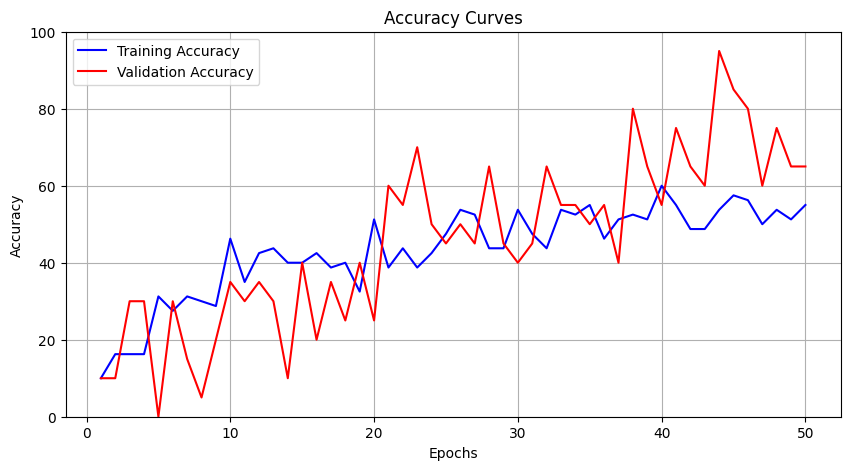

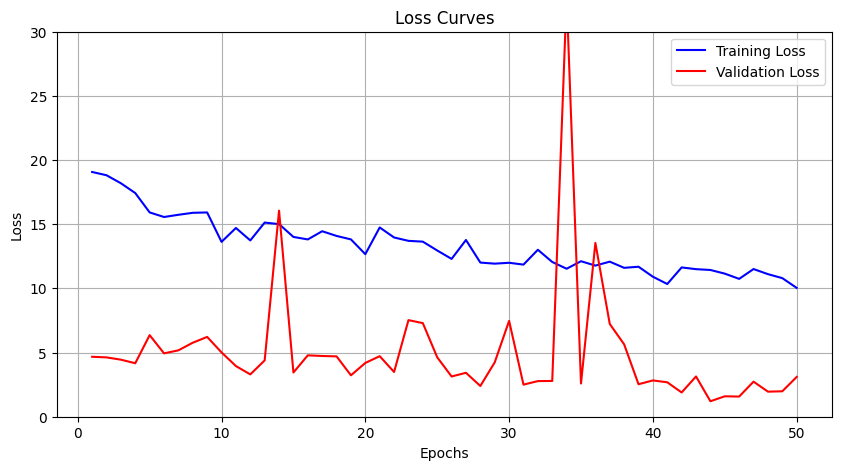

Best train accuracy: 60.0
Best validation accuracy: 95.0


In [25]:
import matplotlib.pyplot as plt

def plot_curves(train_accs, test_accs, train_losses, test_losses):
    epochs = range(1, len(train_accs) + 1)

    # Plot accuracy curves
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accs, 'b', label='Training Accuracy')
    plt.plot(epochs, test_accs, 'r', label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.ylim(0, 100)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, 'b', label='Training Loss')
    plt.plot(epochs, test_losses, 'r', label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, 30)
    plt.legend()
    plt.grid(True)
    plt.show()


plot_curves(train_accs, val_accs, train_losses, val_losses)
print(f'Best train accuracy: {max(train_accs)}')
print(f'Best validation accuracy: {max(val_accs)}')

### Testing

In [ ]:
test_loss, test_acc = test(epoch, test_loader)
print('Test Loss: %.3f | Acc: %.3f%%' % (test_loss, test_acc))

Test Loss: 1950.038 | Acc: 55.580%


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   resent50(pretrained)  | 100 | 0.95 | 0.556 |

# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

1. Translation: Moving an object within the image can change its position relative to the frame, potentially causing it to be partially or completely outside the image boundaries.
2. Rotation: Rotating an object can cause it to be partially or completely outside the image boundaries or result in cropping parts of the object.
3. Scaling: Resizing an image can cause distortion or loss of important details, especially when scaling down significantly.
4. Color changes: Changes in lighting conditions or color transformations can alter the appearance of objects in the image, making them harder to recognize.
To tackle these issues, several ideas can be proposed:

To tackle these issues, there are some ideas:
1. Data Augmentation: Generate additional training data by applying random transformations such as translations, rotations, scaling, and color changes to the original images. This helps the model become more robust to variations in the input data.
2. Padding: Add padding to the images before applying transformations to ensure that no important information is lost due to boundary effects. This can be done by filling the extra space with zeros or using reflection padding.
3. Normalization: Normalize the pixel values of the images to a standard scale, such as [0, 1] or [-1, 1], to reduce the impact of variations in lighting conditions and color changes.
4. Data Balancing: Ensure that the augmented dataset maintains the same class distribution as the original dataset to prevent bias towards certain classes during training.
5. Adaptive Resizing: Resize the images dynamically based on their aspect ratio and content to minimize distortion and loss of important details.
6. Feature Extraction: Use deep learning models that are inherently robust to variations in the input data, such as convolutional neural networks (CNNs), which can learn hierarchical representations of the input images and capture spatial dependencies effectively.

## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [22]:
# Define transformations

weights = ResNet50_Weights.DEFAULT
preprocess = weights.transforms()


train_transform = transforms.Compose([
    transforms.RandomRotation(45),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.3, 0.3), shear=0.3, scale=(0.7, 1.3)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#might not need it, replaced by preprocess by resnet50 weights
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_set = datasets.CIFAR10(
    root='./data', train=True, download=True,
    transform=train_transform
    )
test_set = datasets.CIFAR10(
    root='./data', train=False, download=True,
    transform=preprocess
    )

# Create a subset containing only the first 100 samples
subset_indices = list(range(100))
dataset = Subset(train_set, subset_indices)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [21]:
# Define new architecture
model = resnet50(weights=ResNet50_Weights)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 128MB/s]


In [23]:
lr = 0.001
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4, nesterov=False)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
model = model.to(device)

#######################START TRAINING############################
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True)

train_accs = []
train_losses = []
val_accs = []
val_losses = []

for fold, (train_indices, val_indices) in enumerate(kf.split(dataset)):
    print(f"Fold {fold+1}/{num_folds}")

    # Split the dataset
    train_set = torch.utils.data.Subset(dataset, train_indices)
    val_set = torch.utils.data.Subset(dataset, val_indices)
    # training and validation sets
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        # Training
        train_loss, train_acc = train(epoch, train_loader)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        # Validation
        val_loss, val_acc = test(epoch, val_loader)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

        scheduler.step()

Fold 1/5
Epoch 1/10, Validation Loss: 4.6713, Accuracy: 10.00%
Epoch 2/10, Validation Loss: 4.6238, Accuracy: 10.00%
Epoch 3/10, Validation Loss: 4.4451, Accuracy: 30.00%
Epoch 4/10, Validation Loss: 4.1674, Accuracy: 30.00%
Epoch 5/10, Validation Loss: 6.3569, Accuracy: 0.00%
Epoch 6/10, Validation Loss: 4.9383, Accuracy: 30.00%
Epoch 7/10, Validation Loss: 5.1729, Accuracy: 15.00%
Epoch 8/10, Validation Loss: 5.7671, Accuracy: 5.00%
Epoch 9/10, Validation Loss: 6.2188, Accuracy: 20.00%
Epoch 10/10, Validation Loss: 5.0118, Accuracy: 35.00%
Fold 2/5
Epoch 1/10, Validation Loss: 3.9487, Accuracy: 30.00%
Epoch 2/10, Validation Loss: 3.2979, Accuracy: 35.00%
Epoch 3/10, Validation Loss: 4.3881, Accuracy: 30.00%
Epoch 4/10, Validation Loss: 16.0590, Accuracy: 10.00%
Epoch 5/10, Validation Loss: 3.4447, Accuracy: 40.00%
Epoch 6/10, Validation Loss: 4.7838, Accuracy: 20.00%
Epoch 7/10, Validation Loss: 4.7328, Accuracy: 35.00%
Epoch 8/10, Validation Loss: 4.7026, Accuracy: 25.00%
Epoch 9/10

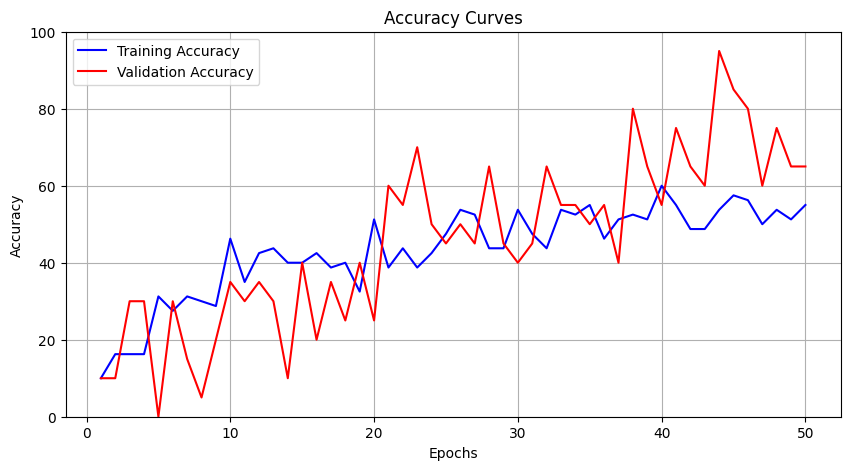

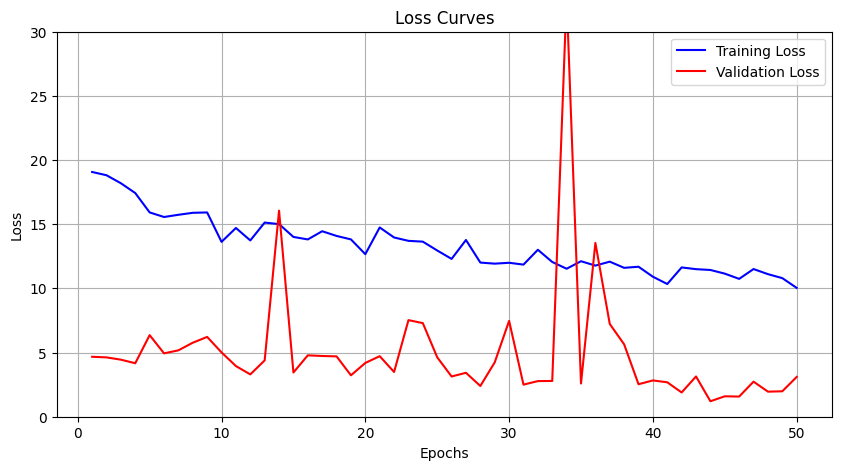

Best train accuracy: 60.0
Best test accuracy: 95.0


In [26]:
plot_curves(train_accs, val_accs, train_losses, val_losses)
print(f'Best train accuracy: {max(train_accs)}')
print(f'Best test accuracy: {max(val_accs)}')

### Testing

In [ ]:
test_loss, test_acc = test(epoch, test_loader)
print('Test Loss: %.3f | Acc: %.3f%%' % (test_loss, test_acc))

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   resnet50 (data aug)  | 100 | 0.95 |  |

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

1. Transfer learning using pretrained model: for resnet50, we try several ways to train the last layers. First we simply replace the last fully connected layer to fit our output dimension. Second we then experiment with adding a whole new block consisted of 2-3 fc layers with relu and dropout in between, in order to decrease the dimension more gradually (since output dim from conv layer is 1024 and output dim is 10). However, the first one shows better accuracy. We esitmate that if we retrain the parameters even in conv layers from scratch, there is little room to improve given a extremely small training set. So learning the last classification layer should be enough.
2. Data augmentation:

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.